# Diode notebook

## How to use the diode to test the timing of your stimulus wrt your triggers

In [16]:
%matplotlib inline
#%matplotlib widget

In [17]:
#importing modules
import os
import pip

import numpy as np
%pip install mne
import mne # type: ignore

%pip install pandas
%pip install scikit-learn


import pandas as pd
import sklearn

import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from pathlib import Path


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
# reading the file & loading in the data
# Define the subject and file path
eeg_subj = 'Group12_own' # this is mads I hope
data_raw_file = os.path.join("/Users/lina/Documents/GitHub/ore_EEG/data/", eeg_subj + '.vhdr')

raw = mne.io.read_raw_brainvision(data_raw_file, eog = ('HEOG', 'VEOG'), misc = ["41"])
raw.info['bads'] = []

raw.load_data()

Extracting parameters from /Users/lina/Documents/GitHub/ore_EEG/data/Group12_own.vhdr...
Setting channel info structure...
Reading 0 ... 523239  =      0.000 ...   523.239 secs...


/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_12939/3634630922.py:6: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(data_raw_file, eog = ('HEOG', 'VEOG'), misc = ["41"])


Measurement date,"February 29, 2024 14:26:11 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"30 EEG, 2 EOG, 1 misc"
Bad channels,None
EOG channels,"HEOG, VEOG"
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,1000.00 Hz


### Setting montage and common ave referencing

In [21]:
# selecting only EEG and stimulus data & plotting raw data
montage = mne.channels.make_standard_montage('standard_1020')

raw.set_montage(montage, verbose=False)
#raw.pick_types(meg=False, eeg=True, eog=True, stim=True, exclude=[])
raw.pick_types(meg=False, eeg=True, eog=True, misc=True, exclude=[])
raw.set_eeg_reference(ref_channels='average', ch_type='eeg')

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Applying average reference.
Applying a custom ('EEG',) reference.


Measurement date,"February 29, 2024 14:26:11 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,"30 EEG, 2 EOG, 1 misc"
Bad channels,None
EOG channels,"HEOG, VEOG"
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,1000.00 Hz


## [Straight to] Epoching
We now want to create epochs according to the events in our data, e.g. stimuli presentation. First, we locate the events and name our event IDs.

In [22]:
# this function locates any stimulus events in the recording (e.g. presentation of stimuli or button presses)
events, events_id = mne.events_from_annotations(raw)

np.unique(events[:,2])

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 20', 'Stimulus/S 30', 'Stimulus/S 40', 'Stimulus/S 50', 'Stimulus/S 54', 'Stimulus/S 58', 'Stimulus/S 62', 'Stimulus/S130', 'Stimulus/S140', 'Stimulus/S150', 'Stimulus/S156', 'Stimulus/S158', 'Stimulus/S170', 'Stimulus/S172', 'Stimulus/S220', 'Stimulus/S222', 'Stimulus/S252']


array([   20,    30,    40,    50,    54,    58,    62,   130,   140,
         150,   156,   158,   170,   172,   220,   222,   252, 99999])

In [23]:
# deleting spurious triggers (e.g. from the trigger not be re-set between triggers events)
#If dif < 2 for trigger onsets, then reject preceding trial - i.e. if there's only 1 ms between triggers
dif_onsets = np.diff(events[:,0])
dif_idx = np.where(dif_onsets<2)[0]
events = np.delete(events, dif_idx, axis = 0)
print('event number {} was rejected'.format(dif_idx))

event number [   2    4    9   11   13   15   17   20   22   24   29   31   33   35
   38   40   42   44   46   48   50   53   55   59   61   63   65   70
   72   74   76   78   80   82   84   90   92   94   99  101  103  106
  108  110  112  114  123  125  127  129  131  133  135  138  140  142
  144  146  151  153  156  159  162  166  168  171  173  175  178  180
  183  185  188  190  193  195  197  200  203  205  207  211  213  216
  218  221  223  228  230  233  235  238  241  246  251  254  258  261
  263  274  277  279  281  283  291  294  297  300  302  304  307  310
  320  322  324  326  329  332  335  338  341  344  347  351  353  356
  363  365  371  374  377  380  389  391  393  396  399  402  407  410
  413  418  421  424  427  432  437  440  445  448  453  456  459  462
  465  468  471  474  483  486  489  492  495  498  501  504  507  510
  512  514  519  521  523  526  529  531  533  540  543  546  548  550
  553  556  559  564  566  568  570  572  574  576  579  581  58

### Trigger codes we used in our experiment 
Image onset triggers: 
- happy: 20.
- sad: 30.
- neutral: 40
Response triggers: 
- 'e' (sad): 100.
- 'i' (happy): 200.

Right and wrong responses: 
correct classified as sad image: 130
correct classified as happy image: 220
neutral image and answer correctly (either?): 140
incorrectly: 50



In [28]:

# import new data 
behav_data_new = pd.read_csv("/Users/lina/Documents/GitHub/ore_EEG/data/cleaned_logfile_sub1.csv") # mads data I think

counter = 0
for event in events:
    if event[-1] in [20, 30, 40]:

        # Get the corresponding event from the behavioral data
        behav_event = behav_data_new.iloc[counter]
        counter += 1

        # Extract relevant information from the behav_event
        ethnicity_trigger = behav_event["ethnicity_trigger"]
        
        # Assign event numbers based on the ethnicity_trigger value
        if ethnicity_trigger == 41:
            event[-1] = 41
        elif ethnicity_trigger == 42:
            event[-1] = 42
        elif ethnicity_trigger == 43:
            event[-1] = 43
        elif ethnicity_trigger == 31:
            event[-1] = 31
        elif ethnicity_trigger == 32:
            event[-1] = 32
        elif ethnicity_trigger == 33:
            event[-1] = 33
        elif ethnicity_trigger == 21:
            event[-1] = 21
        elif ethnicity_trigger == 22:
            event[-1] = 22
        elif ethnicity_trigger == 23:
            event[-1] = 23
        else:
            # case where the ethnicity_trigger value is unknown or not found
            event[-1] = 77

for event in events: 
    print(event[-1])


99999
42
140
22
220
22
220
42
140
32
130
21
220
43
140
22
220
21
220
33
130
33
130
32
130
42
140
43
140
33
130
32
130
23
220
33
130
33
130
23
220
21
220
43
140
32
130
33
130
31
130
22
220
22
220
42
140
21
220
21
220
31
130
21
220
31
130
32
50
22
220
23
220
21
220
21
220
31
130
43
140
32
130
21
220
43
140
42
140
22
220
21
220
42
140
42
140
31
130
32
130
21
220
43
140
42
140
33
130
32
130
22
220
33
130
42
140
23
220
43
140
22
220
42
140
32
130
22
220
23
50
22
220
43
140
43
140
33
130
23
220
32
50
31
130
32
130
31
130
21
220
22
220
42
140
22
220
33
130
21
220
31
130
43
140
23
220
23
220
22
220
21
220
21
220
43
140
42
140
42
140
43
140
22
220
22
220
32
130
22
220
42
140
43
140
32
50
22
220
43
140
32
130
22
220
43
140
33
130
42
140
23
220
42
140
22
220
43
140
32
130
33
130
43
140
43
140
33
130
32
130
23
220
21
220
32
130
31
130
42
140
22
220
32
130
23
220
32
130
42
140
23
220
23
220
23
220
43
140
32
130
21
220
32
130
22
220
43
140
22
220
32
130
23
220
21
220
32
50
42
140
33
130
42
140
42
14

In [35]:
# we can make a dictionary of what the event IDs represent
# creating an event_id for epoching

event_id = {
    'happy/white': 31,
    'happy/asian': 32,
    'happy/black': 33,
   # 'neutral/asian': 41, # not present in this experiment and causes errors if no #
    'neutral/white': 42, 
    'neutral/black': 43,
    'sad/white': 21,
    'sad/black': 22,
    'sad/asian': 23,
    'incorrect': 50,
    'sadcorrect/response': 130,
    'neutral/response': 140,
    'happycorrect/response': 220
}

/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_12939/1334847944.py:2: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=1000, first_samp=raw.first_samp, event_id=event_id);
/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_12939/1334847944.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, sfreq=1000, first_samp=raw.first_samp, event_id=event_id);


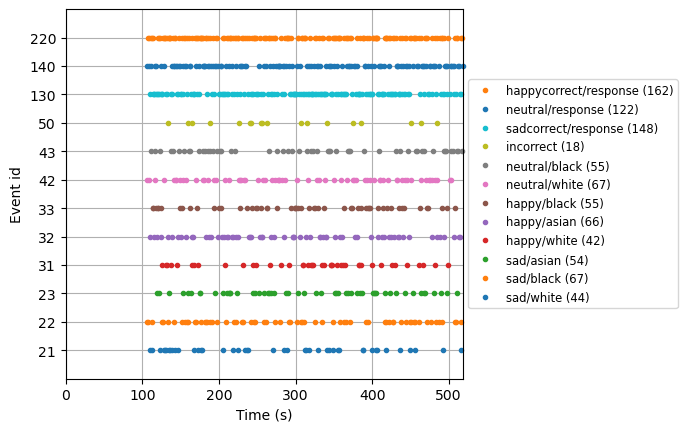

In [36]:
# plotting an overview of the events
mne.viz.plot_events(events, sfreq=1000, first_samp=raw.first_samp, event_id=event_id); 

In [37]:
# for diode timings
#tmin_d, tmax_d = -0.05, 0.1  # in s - setting a very narrow window around the trigger (=0) to be able to better inspect potential delays
tmin_d, tmax_d = -0.01, 0.05  # in s - setting a very narrow window around the trigger (=0) to be able to better inspect potential delays

baseline = None
epochs_diode = mne.Epochs(
    raw,
    events=events,
    event_id=event_id,
    tmin=tmin_d,
    tmax=tmax_d,
    baseline=baseline,
    verbose=False,
)

# Timing delays

Using data from preloaded Raw for 900 events and 61 original time points ...
0 bad epochs dropped
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated


/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_12939/4057598217.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs_diode.plot_image(picks='41');


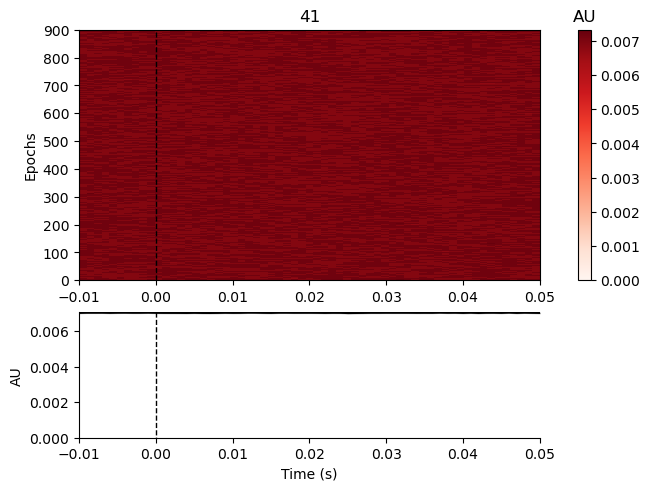

In [38]:
epochs_diode.plot_image(picks='41');

In [39]:
evokeds_diode = epochs_diode.average(picks='misc')

/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_12939/2795768579.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(dict(stim=evokeds_diode), picks='misc', vlines=[0, .033]);


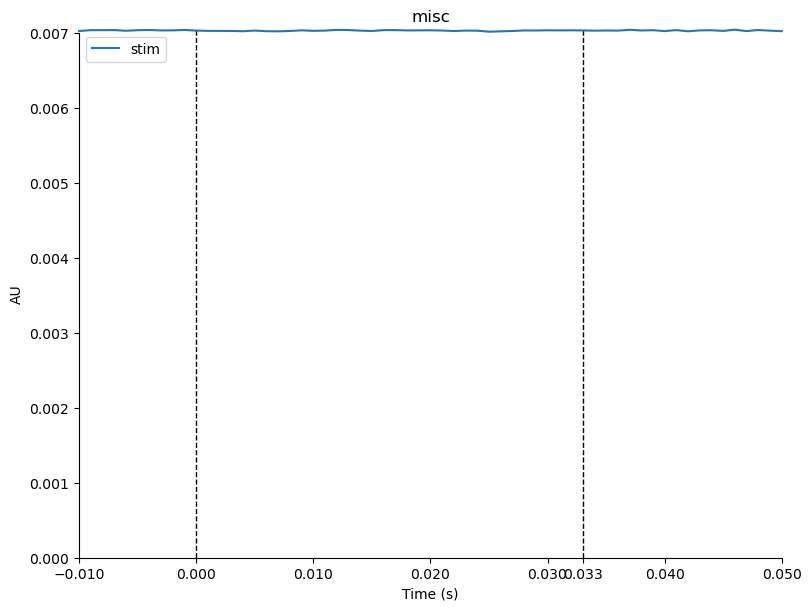

In [40]:
# plotting the averaged diode response across all trials
# - adding a vertical line at 33 ms to illustrate the 2-frame delay
mne.viz.plot_compare_evokeds(dict(stim=evokeds_diode), picks='misc', vlines=[0, .033]);

# Re-adjusting timing (based on diode timing check from above)
Adding 33 ms (= 2 frames) to all trigger timestamps (except the very first trigger which marks the beginning of the file)

In [41]:
# creating a copy of the events-structure so that we can compare with the original events-structure
# after compensation/re-adjusment
events_diode = events.copy()

In [42]:
# having a quick look at the events-strucutre
events_diode[:20, :]

array([[     0,      0,  99999],
       [105588,      0,     42],
       [106247,      0,    140],
       [106439,      0,     22],
       [107196,      0,    220],
       [107386,      0,     22],
       [108130,      0,    220],
       [108323,      0,     42],
       [109056,      0,    140],
       [109239,      0,     32],
       [109880,      0,    130],
       [110056,      0,     21],
       [110657,      0,    220],
       [110856,      0,     43],
       [111642,      0,    140],
       [111840,      0,     22],
       [112370,      0,    220],
       [112556,      0,     21],
       [113120,      0,    220],
       [113307,      0,     33]])

In [43]:
# adding our delay to all timestamps in our event structure (which just marks the beginning of the recording)
events[1:-1,0] = events[1:-1,0]+33

In [44]:
# having a quick look to see that all timestamps have changed accordingly
print(events_diode[:10,:])
print(events[:10,:])
print(events[:10,0]-events_diode[:10,0])

[[     0      0  99999]
 [105588      0     42]
 [106247      0    140]
 [106439      0     22]
 [107196      0    220]
 [107386      0     22]
 [108130      0    220]
 [108323      0     42]
 [109056      0    140]
 [109239      0     32]]
[[     0      0  99999]
 [105621      0     42]
 [106280      0    140]
 [106472      0     22]
 [107229      0    220]
 [107419      0     22]
 [108163      0    220]
 [108356      0     42]
 [109089      0    140]
 [109272      0     32]]
[ 0 33 33 33 33 33 33 33 33 33]


## quick round of epoching and plotting to inspect the effect of re-adjusting the timeline wrt the triggers

In [45]:
# for ERPs
tmin, tmax = -0.1, 0.8  # in s

epochs_adjust = mne.Epochs(
    raw,
    events=events, # using the updated events-timestamps
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    verbose=False,
)

In [46]:
# for ERPs
tmin, tmax = -0.1, 0.8  # in s

epochs_orig = mne.Epochs(
    raw,
    events=events_diode, # using the original events-timestamps
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    verbose=False,
)

## Subsetting

In [48]:
nw_adjust = epochs_adjust['neutral/white']
nb_adjust = epochs_adjust['neutral/black']

sw_adjust = epochs_adjust['sad/white']
sb_adjust = epochs_adjust['sad/black']
sa_adjust = epochs_adjust['sad/asian']

hw_adjust = epochs_adjust['happy/white']
hb_adjust = epochs_adjust['happy/black']
ha_adjust = epochs_adjust['happy/asian']

# original
nw_orig = epochs_orig['neutral/white']
nb_orig = epochs_orig['neutral/black']

sw_orig = epochs_orig['sad/white']
sb_orig = epochs_orig['sad/black']
sa_orig = epochs_orig['sad/asian']

hw_orig = epochs_orig['happy/white']
hb_orig = epochs_orig['happy/black']
ha_orig = epochs_orig['happy/asian']



## Plotting epochs

Using data from preloaded Raw for 900 events and 901 original time points ...
0 bad epochs dropped
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


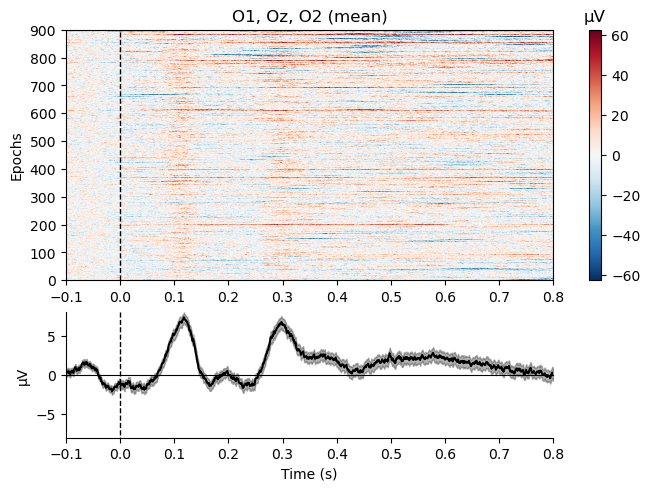

Using data from preloaded Raw for 900 events and 901 original time points ...
0 bad epochs dropped
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


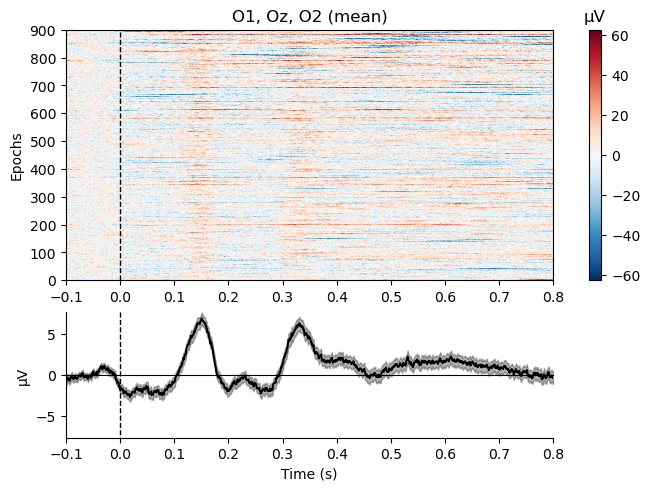

In [49]:
# plotting from channels over occipital cortex (looking for P1-N1-P2)
picks = ['O1','Oz','O2']
epochs_adjust.plot_image(picks=picks, combine='mean');
epochs_orig.plot_image(picks=picks, combine='mean');

Using data from preloaded Raw for 55 events and 901 original time points ...
0 bad epochs dropped
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


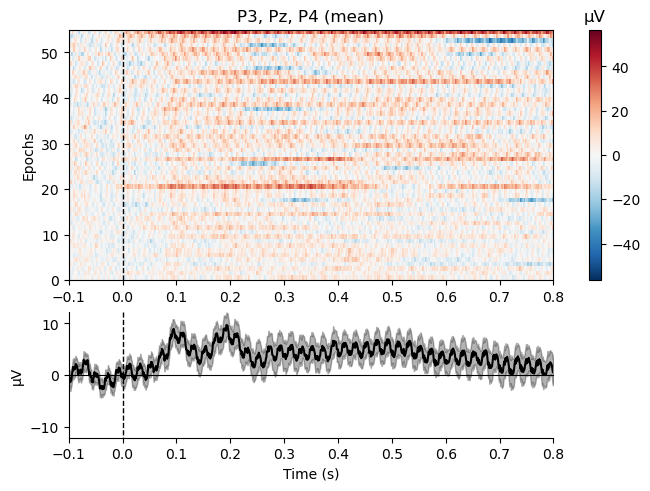

Using data from preloaded Raw for 55 events and 901 original time points ...
0 bad epochs dropped
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


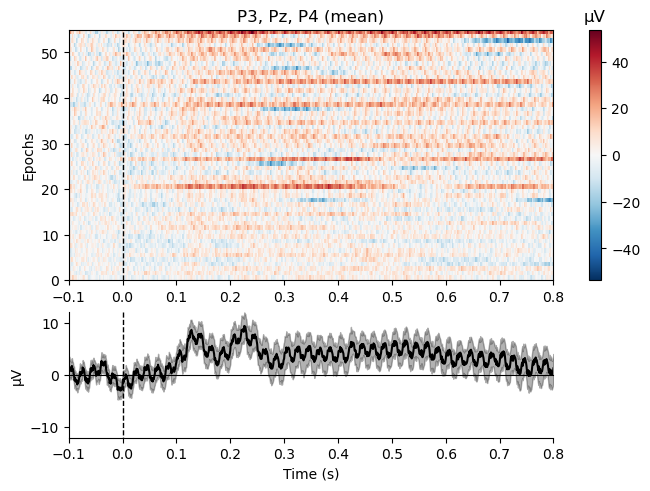

In [51]:
# plotting from channels over parietal cortex (potential P3) - and only the one event type
picks = ['P3','Pz','P4']
hb_adjust.plot_image(picks=picks, combine='mean');
hb_orig.plot_image(picks=picks, combine='mean');

# Evoked

In [57]:
# Compute averages for the adjusted epochs
evoked_nw_adjust = nw_adjust.average()
evoked_nb_adjust = nb_adjust.average()

evoked_sw_adjust = sw_adjust.average()
evoked_sb_adjust = sb_adjust.average()
evoked_sa_adjust = sa_adjust.average()

evoked_hw_adjust = hw_adjust.average()
evoked_hb_adjust = hb_adjust.average()
evoked_ha_adjust = ha_adjust.average()

# Compute averages for the original epochs
evoked_nw_orig = nw_orig.average()
evoked_nb_orig = nb_orig.average()

evoked_sw_orig = sw_orig.average()
evoked_sb_orig = sb_orig.average()
evoked_sa_orig = sa_orig.average()

evoked_hw_orig = hw_orig.average()
evoked_hb_orig = hb_orig.average()
evoked_ha_orig = ha_orig.average()
# generally 
evoked_adjust = epochs_adjust.average()
evoked_orig = epochs_orig.average()

No projector specified for this dataset. Please consider the method self.add_proj.


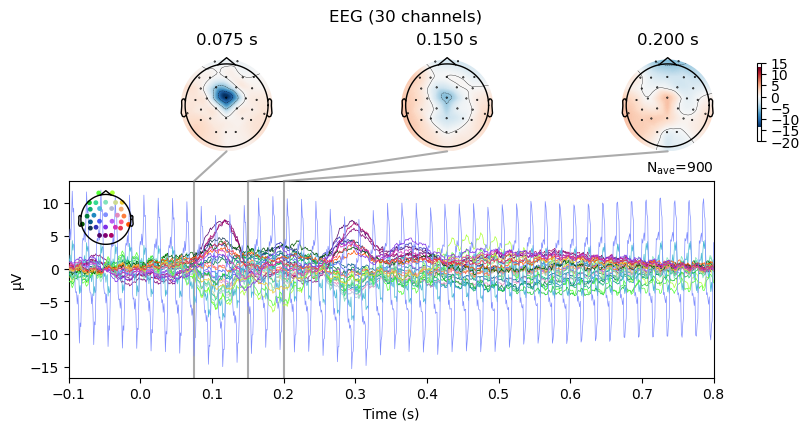

No projector specified for this dataset. Please consider the method self.add_proj.


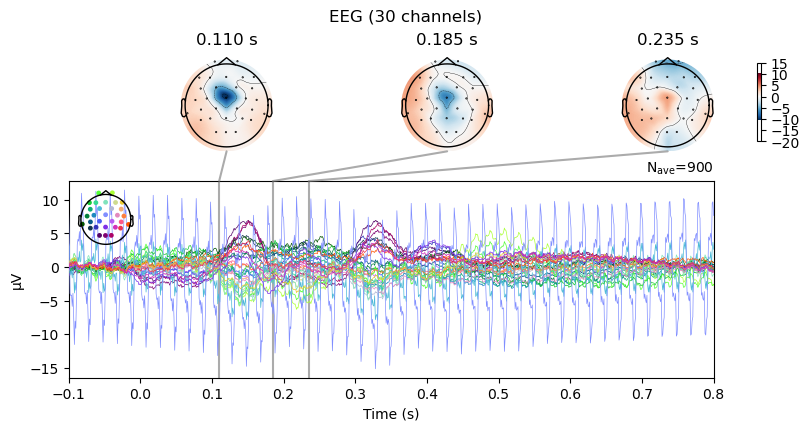

In [58]:
times_adjust = [0.075, 0.15, 0.2]
times_orig = [0.11, 0.185, 0.235]

evoked_adjust.plot_joint(times=times_adjust);
evoked_orig.plot_joint(times=times_orig);

No projector specified for this dataset. Please consider the method self.add_proj.


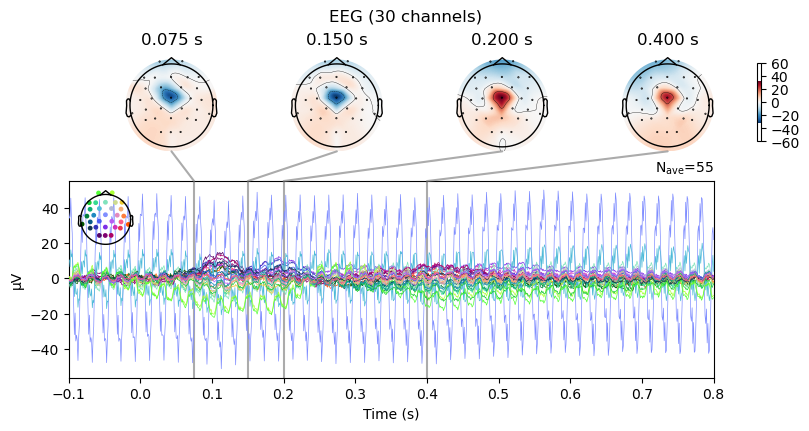

No projector specified for this dataset. Please consider the method self.add_proj.


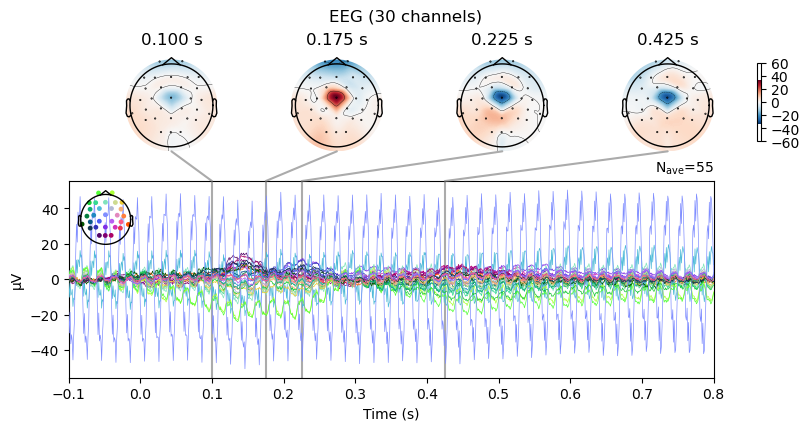

In [60]:
times_adjust = [0.075, 0.15, 0.2, 0.4]
times_orig = [0.1, 0.175, 0.225, 0.425]

evoked_hb_adjust.plot_joint(times=times_adjust);
evoked_hb_orig.plot_joint(times=times_orig);

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


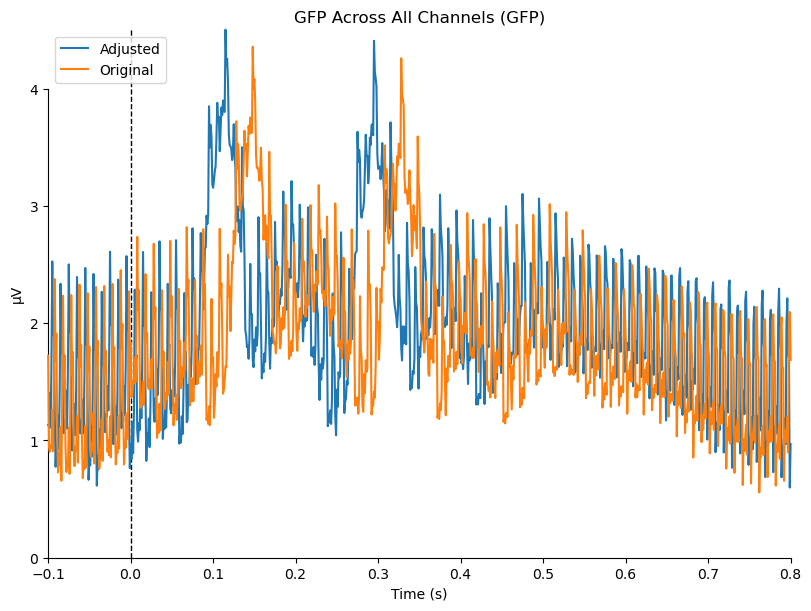

combining channels using "mean"
combining channels using "mean"


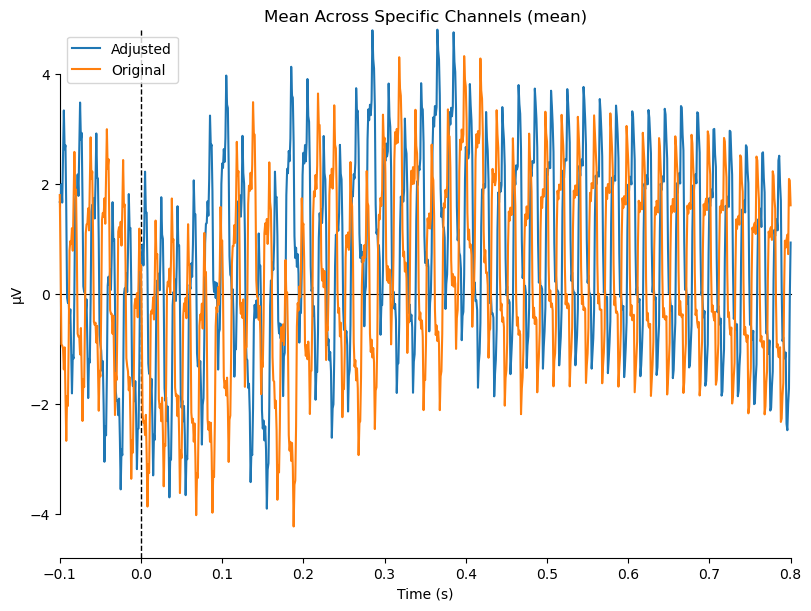

[<Figure size 800x600 with 1 Axes>]

In [64]:
# Plotting GFP across all channels for both adjusted and original epochs
mne.viz.plot_compare_evokeds({'Adjusted': evoked_adjust, 'Original': evoked_orig}, title='GFP Across All Channels')

# Plotting mean across specific channels for both adjusted and original epochs
mne.viz.plot_compare_evokeds({'Adjusted': evoked_adjust, 'Original': evoked_orig}, picks=picks, combine='mean', title='Mean Across Specific Channels')

